In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

from collections import OrderedDict
from pathlib import Path
import pandas as pd 
import numpy as np
import re 
import joblib
import gc
from time import sleep

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

curruser = os.environ.get('USER')

isUseOptWorkspace = False
sys.path.insert(0, './../src')

if isUseOptWorkspace:
    sys.path.insert(0, '/opt/workspace/{}/notebooks/ecom_model/src/'.format(curruser))
    sys.path.insert(0, '/opt/workspace/{}/notebooks/support_library/'.format(curruser)) 
    sys.path.insert(0, '/opt/workspace/{}/libs/python3.5/site-packages/'.format(curruser))
    sys.path.insert(0, '/opt/workspace/{}/notebooks/labdata/lib/'.format(curruser))
else:
    sys.path.insert(0, '/home/{}/notebooks/ecom_model/src/'.format(curruser))
    sys.path.insert(0, '/home/{}/notebooks/support_library/'.format(curruser)) 
    sys.path.insert(0, '/home/{}/python35-libs/lib/python3.5/site-packages/'.format(curruser))
    sys.path.insert(0, '/home/{}/notebooks/labdata/lib/'.format(curruser))

from plot import Plot
from preprosessing import Preproc
from corpora_transform_main import TfIdfFastTextEmbedVectorizer

# from tqdm import tqdm
# from tqdm._tqdm_notebook import tqdm_notebook
# tqdm_notebook.pandas()

from spark_connector import SparkConnector
from sparkdb_loader import spark
# from spark_helper import SparkHelper
from connector import OracleDB
import pyspark
from pyspark import SparkContext, SparkConf, HiveContext, SparkFiles
from pyspark.sql import functions as f
from pyspark.sql.window import Window
from pyspark.sql.types import *
from pyspark.sql.dataframe import DataFrame
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer

import loader as load

from corpora_process import utils
from processing import Preproc_Response
import time
from tqdm import tqdm_notebook
from datetime import datetime
from dateutil.relativedelta import relativedelta

from itertools import islice
from multiprocessing import Pool, Process, JoinableQueue
from multiprocessing.pool import ThreadPool
from functools import partial
import numpy as np
import subprocess
from threading import Thread
from joblib import Parallel, delayed

from gensim.models.fasttext import FastText as FT_gensim
from gensim.corpora import Dictionary
from gensim import corpora
from gensim.models import TfidfModel
from gensim.test.utils import datapath
from gensim.utils import tokenize
from gensim.test.utils import common_texts

In [3]:
def drop_col(df, cols: list):
    scol = sdf.columns
    final_cols = [i for i in scol if i not in cols]
    return df.select(*final_cols)

def show(self, n=10):
    return self.limit(n).toPandas()
pyspark.sql.dataframe.DataFrame.show = show

In [4]:
%%time
sp = spark(schema='sbx_team_digitcamp', 
           sparkVersion='2.2',
           dynamic_alloc=False,
           numofinstances=35, 
           numofcores=8,
           kerberos_auth=False) 
print(sp.sc.version)
hive = sp.sql

2.4.0.cloudera2
CPU times: user 28.1 ms, sys: 28.5 ms, total: 56.6 ms
Wall time: 22.3 s


### Collect all user responses for the whole historical period

In [5]:
all_sdf = hive.sql('''
with
--v0.0.7
--04.12.2019 19:20
w_resp as(
      select 
        regexp_extract(organization_id, '(\\\\d{10,12})(?:_)') as inn,
        regexp_extract(organization_id, '(?:_)(\\\\d{3,})')    as kpp,
        organization_id,
        concat_ws('_', organization_id, resp_tracking_cd) as custid_value,
        campaign_nm,
        response_dttm,
        response,
        load_dt
        
       from sbx_team_digitcamp.sme_cdm_v_response
      where lower(response) rlike '^(?=.*sendsay)(?!.*(ошиб|отпис|спам|не удалось|в процессе|доставлено)).*' 
        --and load_dt <= timestamp('%s')
        --and organization_id like '%6446004324%'  
        --and organization_id like '%6454010956%'
        
),
w_send as (
    select 
      regexp_extract(organization_id, '(\\\\d{10,12})(?:_)') as inn,
      regexp_extract(organization_id, '(?:_)(\\\\d{3,})') as kpp,
      organization_id,
      tracking_id as custid_value,
      campaign_nm,
      int_update_dttm as response_dttm,
      'SendSay. Сообщение доставлено' as response,
      load_dt,
      email, email_subject,
      customer_text_01, customer_text_02, customer_text_03, customer_text_04, customer_text_05,
      customer_text_06, customer_text_07, customer_text_08, customer_text_09, customer_text_10,
      customer_text_11, customer_text_12, customer_text_13, customer_text_14, customer_text_15,
      customer_text_16, customer_text_17, customer_text_18, customer_text_19, customer_text_20,
      message_title
    from sbx_team_digitcamp.sme_email_to_sendsay
   where 1=1
     --and load_dt <= timestamp('%s')
     --and organization_id like '%6446004324%'  
     --and organization_id like '%6454010956%'
),
w_only_send as (
    select s.* from (select distinct organization_id from w_resp) r
        left join w_send s on r.organization_id = s.organization_id 
),
w_base as(
    select * from 
    (--text columns in line for response
        select 
         row_number() over (partition by r.organization_id, r.campaign_nm, r.response_dttm, r.response order by r.response_dttm) as rn,
         r.inn, r.kpp, r.organization_id, r.custid_value, r.campaign_nm, r.response_dttm, r.response,
         r.load_dt,
         s.email, s.email_subject,
         s.customer_text_01, s.customer_text_02, s.customer_text_03, s.customer_text_04, s.customer_text_05,
         s.customer_text_06, s.customer_text_07, s.customer_text_08, s.customer_text_09, s.customer_text_10,
         s.customer_text_11, s.customer_text_12, s.customer_text_13, s.customer_text_14, s.customer_text_15,
         s.customer_text_16, s.customer_text_17, s.customer_text_18, s.customer_text_19, s.customer_text_20,
         s.message_title
        from w_resp r
        left join w_only_send s on r.organization_id = s.organization_id
                              and r.campaign_nm = s.campaign_nm                 
         where length(r.inn) >=10
        ) where rn = 1
    
    union

    select '' as rn, * from w_only_send
     where length(inn) >=10
)
select 
       inn
      ,kpp 
      ,campaign_nm 
      ,organization_id
      ,custid_value
      ,response_dttm
      ,response
      ,date_format(response_dttm, 'yyyy-MM-dd') as asday
      ,date_format(last_day(response_dttm), 'yyyy-MM-dd') as last_day
      ,date_format(response_dttm, 'HH:mm:ss') as astime
      ,date_format(response_dttm, 'HH') as ashour
      ,date_format(response_dttm, 'EEEE') as asdayname
      ,load_dt
      ,email
      ,email_subject,
      customer_text_01, customer_text_02, customer_text_03, customer_text_04, customer_text_05,
      customer_text_06, customer_text_07, customer_text_08, customer_text_09, customer_text_10,
      customer_text_11, customer_text_12, customer_text_13, customer_text_14, customer_text_15,
      customer_text_16, customer_text_17, customer_text_18, customer_text_19, customer_text_20,
      message_title    
from w_base   
''') #% (max_load_dt_str, max_load_dt_str))

### Collect a list of daytime values based on the distinct values of `last_day` column

In [6]:
last_day_rows = all_sdf.select('last_day').distinct().collect()
last_day_lst = [day['last_day'] for day in last_day_rows if day['last_day'] is not None]
last_day_dt = sorted([datetime.strptime(day_str, '%Y-%m-%d') for day_str in last_day_lst])

last_day_dt[-1]

datetime.datetime(2020, 7, 31, 0, 0)

### TRAIN sampling 

In [7]:
tr_sdf = all_sdf.filter((f.col('response_dttm') > last_day_dt[-4])&(f.col('response_dttm') < last_day_dt[-2]))

## Find min value of `response_dttm` in Train dataset

In [8]:
resp_dttm_min = tr_sdf.select(f.min('response_dttm')).collect()
resp_dttm_min_str = resp_dttm_min[0]['min(response_dttm)']
resp_dttm_min_str

datetime.datetime(2020, 4, 30, 5, 30, 19)

## Roll back by 3 month from the min value of `last_open_time` and generate a temp dataframe for feature generation process

In [9]:
sendsay_delivered = 'SendSay. Сообщение доставлено'
sendsay_openpage  = 'SendSay. Открытие страницы'
sendsay_openlink  = 'SendSay. Переход по ссылке' 

In [10]:
tr_sdf = tr_sdf \
        .withColumn('first_send_time', 
                    f.min(f.when(f.col('response') == sendsay_delivered, f.col('response_dttm')).otherwise(None))\
                    .over(Window.partitionBy('inn', 'kpp', 'campaign_nm')))\
        .withColumn('last_send_time', 
                    f.max(f.when(f.col('response') == sendsay_delivered, f.col('response_dttm')).otherwise(None))\
                    .over(Window.partitionBy('inn', 'kpp', 'campaign_nm')))\
        .withColumn('first_open_time', 
                    f.min(f.when((f.col('response') == sendsay_openpage), f.col('response_dttm')).otherwise(None))\
                    .over(Window.partitionBy('inn', 'kpp', 'campaign_nm')))\
        .withColumn('last_open_time', 
                    f.max(f.when((f.col('response') == sendsay_openpage), f.col('response_dttm')).otherwise(None))\
                    .over(Window.partitionBy('inn', 'kpp', 'campaign_nm')))\
        .withColumn('first_click_time', 
                    f.min(f.when((f.col('response') == sendsay_openlink), f.col('response_dttm')).otherwise(None))\
                    .over(Window.partitionBy('inn', 'kpp', 'campaign_nm')))\
        .withColumn('last_click_time', 
                    f.max(f.when((f.col('response') == sendsay_openlink),f.col('response_dttm')).otherwise(None))\
                                      .over(Window.partitionBy('inn', 'kpp', 'campaign_nm')))

In [11]:
shiftd = 90
shift_back  = tr_sdf.select(f.last_day(f.add_months(f.trunc(f.from_unixtime(f.unix_timestamp(f.min('last_open_time')) - shiftd*24*60*60),'MM'),-1)).alias('monthback')).collect()
shift_back  = shift_back[0]['monthback']
shift_back

datetime.date(2019, 12, 31)

In [12]:
train_sdf = all_sdf.filter((f.col('response_dttm') >= shift_back)&(f.col('response_dttm') < last_day_dt[-2]))

### TARGET sampling

In [13]:
target_sdf = all_sdf.filter((f.col('response_dttm') > last_day_dt[-2]) & 
                            (f.col('response_dttm') < last_day_dt[-1]))\
                    .select(f.col('inn').alias('inn_'),
                            f.col('kpp').alias('kpp_'),
                            f.col('campaign_nm').alias('campaign_nm_'),
                            f.col('email').alias('email_'),
                            f.col('response').alias('response_'),
                            f.col('response_dttm').alias('response_dttm_'))

In [14]:
target_sdf =\
target_sdf.withColumn('target', f.when(f.col('response_') == 'SendSay. Находится в стоп-листе',-1)\
                                 .when(f.col('response_') == 'SendSay. Сообщение доставлено',0)\
                                 .when(f.col('response_') == 'SendSay. Открытие страницы',1)\
                                 .when(f.col('response_') == 'SendSay. Переход по ссылке',2)\
                                 .otherwise(-1))

### Join train with target

In [15]:
cols = train_sdf.columns+['target']

cond = [train_sdf.inn         == target_sdf.inn_, 
        train_sdf.kpp         == target_sdf.kpp_,
        #train_sdf.campaign_nm == target_sdf.campaign_nm_,
        train_sdf.email       == target_sdf.email_,
        #train_sdf.response    == target_sdf.response_,
        #train_sdf.response_dttm == target_sdf.response_dttm_
       ]

sdf = train_sdf.join(target_sdf, on=cond, how='left_outer')
sdf = sdf.select(*cols)

In [16]:
sdf = sdf.dropDuplicates().filter("target is not Null")

In [17]:
sdf.cache()

DataFrame[inn: string, kpp: string, campaign_nm: string, organization_id: string, custid_value: string, response_dttm: timestamp, response: string, asday: string, last_day: string, astime: string, ashour: string, asdayname: string, load_dt: timestamp, email: string, email_subject: string, customer_text_01: string, customer_text_02: string, customer_text_03: string, customer_text_04: string, customer_text_05: string, customer_text_06: string, customer_text_07: string, customer_text_08: string, customer_text_09: string, customer_text_10: string, customer_text_11: string, customer_text_12: string, customer_text_13: string, customer_text_14: string, customer_text_15: string, customer_text_16: string, customer_text_17: string, customer_text_18: string, customer_text_19: string, customer_text_20: string, message_title: string, target: int]

In [18]:
sdf.count()

40981213

# Main Features Generation Pipeline

## Find inactive users (users without any open/click activity among overall history of communication) 

In [19]:
sdf = sdf \
        .withColumn('first_send_time', 
                    f.min(f.when(f.col('response') == sendsay_delivered, f.col('response_dttm')).otherwise(None))\
                    .over(Window.partitionBy('inn', 'kpp', 'campaign_nm')))\
        .withColumn('last_send_time', 
                    f.max(f.when(f.col('response') == sendsay_delivered, f.col('response_dttm')).otherwise(None))\
                    .over(Window.partitionBy('inn', 'kpp', 'campaign_nm')))\
        .withColumn('first_open_time', 
                    f.min(f.when((f.col('response') == sendsay_openpage), f.col('response_dttm')).otherwise(None))\
                    .over(Window.partitionBy('inn', 'kpp', 'campaign_nm')))\
        .withColumn('last_open_time', 
                    f.max(f.when((f.col('response') == sendsay_openpage), f.col('response_dttm')).otherwise(None))\
                    .over(Window.partitionBy('inn', 'kpp', 'campaign_nm')))\
        .withColumn('first_click_time', 
                    f.min(f.when((f.col('response') == sendsay_openlink), f.col('response_dttm')).otherwise(None))\
                    .over(Window.partitionBy('inn', 'kpp', 'campaign_nm')))\
        .withColumn('last_click_time', 
                    f.max(f.when((f.col('response') == sendsay_openlink),f.col('response_dttm')).otherwise(None))\
                                      .over(Window.partitionBy('inn', 'kpp', 'campaign_nm')))

In [20]:
inactive_freshhold_min = 2
inactive_freshhold_max = 20

In [21]:
sdf = sdf.withColumn('sum_open_click', 
                     f.sum(f.when((f.col('response') == sendsay_openpage)|\
                                  (f.col('response') == sendsay_openlink),1).otherwise(0))\
                                                           .over(Window.partitionBy('inn', 'kpp', 'email')))

sdf = sdf.withColumn('sum_open_click_camp', 
                     f.sum(f.when((f.col('response') == sendsay_openpage)|\
                                  (f.col('response') == sendsay_openlink),1).otherwise(0))\
                                                           .over(Window.partitionBy('inn', 'kpp', 'campaign_nm', 'email')))

sdf = sdf.withColumn('delivery_all_cnt', 
                                         f.sum((f.col('response') == sendsay_delivered).cast('integer')) \
                                          .over(Window.partitionBy('inn', 'kpp', 'email')).cast('integer'))

In [22]:
sdf = sdf.withColumn('fresh_user', f.when((f.col('sum_open_click') == 0) & 
                                          (f.col('delivery_all_cnt') <= inactive_freshhold_min), 1)\
                                    .when((f.col('sum_open_click') == 0) & 
                                          (f.col('delivery_all_cnt') > inactive_freshhold_min), 2).otherwise(0))

In [23]:
sdf = sdf.drop(*['delivery_all_cnt','sum_open_click'])

### Retrospective Features Generation Pipeline

- total biased time events (non-cumulated)

In [24]:
daysback = 30

for i in range(1,4):
    
    dttm_left = f.from_unixtime(f.unix_timestamp(f.col('last_send_time')) - daysback*(i)*24*60*60, 
                                'yyyy-MM-dd HH:mm:ss').cast(TimestampType())

    dttm_right = f.from_unixtime(f.unix_timestamp(f.col('last_send_time')) - daysback*(i-1)*24*60*60, 
                                 'yyyy-MM-dd HH:mm:ss').cast(TimestampType())    
    
    sdf = sdf \
            .withColumn('first_send_time_m{}1'.format(str(i)), 
                        f.min(f.when((f.col('response') == sendsay_delivered) &\
                                     ((f.col('response_dttm')> dttm_left) &\
                                      (f.col('response_dttm')<=dttm_right)), f.col('response_dttm'))\
                                    .otherwise(None))\
                        .over(Window.partitionBy('inn', 'kpp', 'campaign_nm', 'email')))\
            .withColumn('last_send_time_m{}1'.format(str(i)), 
                        f.max(f.when((f.col('response') == sendsay_delivered) &\
                                     ((f.col('response_dttm')> dttm_left) &\
                                      (f.col('response_dttm')<=dttm_right)), f.col('response_dttm'))\
                                    .otherwise(None))\
                        .over(Window.partitionBy('inn', 'kpp', 'campaign_nm', 'email')))

for i in range(1,4):            

    dttm_left = f.from_unixtime(f.unix_timestamp(f.col('last_open_time')) - daysback*(i)*24*60*60, 
                                'yyyy-MM-dd HH:mm:ss').cast(TimestampType())

    dttm_right = f.from_unixtime(f.unix_timestamp(f.col('last_open_time')) - daysback*(i-1)*24*60*60, 
                                 'yyyy-MM-dd HH:mm:ss').cast(TimestampType())

    sdf = sdf \
            .withColumn('first_open_time_m{}1'.format(str(i)), 
                        f.min(f.when((f.col('response') == sendsay_openpage) &\
                                     (f.col('fresh_user')==0)&\
                                     ((f.col('response_dttm')> dttm_left) &\
                                      (f.col('response_dttm')<=dttm_right)), f.col('response_dttm'))\
                                    .otherwise(None))\
                        .over(Window.partitionBy('inn', 'kpp', 'campaign_nm', 'email')))\
            .withColumn('last_open_time_m{}1'.format(str(i)), 
                        f.max(f.when((f.col('response') == sendsay_openpage) &\
                                     (f.col('fresh_user')==0)&\
                                     ((f.col('response_dttm')> dttm_left) &\
                                      (f.col('response_dttm')<=dttm_right)), f.col('response_dttm'))\
                                    .otherwise(None))\
                        .over(Window.partitionBy('inn', 'kpp', 'campaign_nm', 'email')))
            
for i in range(1,4):
    
    dttm_left = f.from_unixtime(f.unix_timestamp(f.col('last_click_time')) - daysback*(i)*24*60*60,
                                'yyyy-MM-dd HH:mm:ss').cast(TimestampType())

    dttm_right = f.from_unixtime(f.unix_timestamp(f.col('last_click_time')) - daysback*(i-1)*24*60*60,
                                 'yyyy-MM-dd HH:mm:ss').cast(TimestampType())
    
    sdf = sdf \
            .withColumn('first_click_time_m{}1'.format(str(i)), 
                        f.min(f.when((f.col('response') == sendsay_openlink) &\
                                     (f.col('fresh_user')==0)&\
                                     ((f.col('response_dttm')> dttm_left) &\
                                      (f.col('response_dttm')<=dttm_right)), f.col('response_dttm'))\
                                    .otherwise(None))\
                        .over(Window.partitionBy('inn', 'kpp', 'campaign_nm', 'email')))\
            .withColumn('last_click_time_m{}1'.format(str(i)), 
                        f.max(f.when((f.col('response') == sendsay_openlink) &\
                                     (f.col('fresh_user')==0)&\
                                     ((f.col('response_dttm')> dttm_left) &\
                                      (f.col('response_dttm')<=dttm_right)), f.col('response_dttm'))\
                                    .otherwise(None))\
                        .over(Window.partitionBy('inn', 'kpp', 'campaign_nm', 'email')))

## Calculate monthly biased time events with `status == sendsay_openpage`

### All statistics

- ACTIVE USERS: total biased time events (non-cumulated)

In [25]:
for i in range(1,4):
    
    dttm_left = f.from_unixtime(f.unix_timestamp(f.col('last_open_time')) - daysback*(i)*24*60*60, 
                                'yyyy-MM-dd HH:mm:ss').cast(TimestampType())

    dttm_right = f.from_unixtime(f.unix_timestamp(f.col('last_open_time')) - daysback*(i-1)*24*60*60, 
                                 'yyyy-MM-dd HH:mm:ss').cast(TimestampType())     
    sdf = sdf \
            .withColumn('last_open_all_cnt_m{}1'.format(str(i)), 
                        f.sum(f.when((f.col('response') == sendsay_openpage) &\
                                     (f.col('fresh_user')==0)&\
                                     ((f.col('response_dttm')> dttm_left) &\
                                      (f.col('response_dttm')<=dttm_right)), 1)\
                                                       .otherwise(0))\
                                                 .over(Window.partitionBy('inn', 'kpp', 'campaign_nm', 'email')).cast('integer'))

### Daytime statistics

- biased time events per day (non-cumulated)

In [26]:
for i in range(1,4):
    
    dttm_left = f.from_unixtime(f.unix_timestamp(f.col('last_open_time')) - daysback*(i)*24*60*60, 
                                'yyyy-MM-dd HH:mm:ss').cast(TimestampType())

    dttm_right = f.from_unixtime(f.unix_timestamp(f.col('last_open_time')) - daysback*(i-1)*24*60*60, 
                                 'yyyy-MM-dd HH:mm:ss').cast(TimestampType())     
    sdf = sdf \
            .withColumn('last_open_day_cnt_m{}1'.format(str(i)), 
                        f.sum(f.when((f.col('response') == sendsay_openpage) &\
                                     (f.col('fresh_user')==0)&\
                                     ((f.col('response_dttm')> dttm_left) &\
                                      (f.col('response_dttm')<=dttm_right)), 1)\
                                                       .otherwise(0))\
                                                 .over(Window.partitionBy('inn', 'kpp', 'campaign_nm', 
                                                                          'email', 'asdayname')).cast('integer'))

## Calculate monthly biased time events with `status == sendsay_openlink`

### All statistics

- total biased time events (non-cumulated)

In [27]:
for i in range(1,4):
    
    dttm_left = f.from_unixtime(f.unix_timestamp(f.col('last_click_time')) - daysback*(i)*24*60*60, 
                                'yyyy-MM-dd HH:mm:ss').cast(TimestampType())

    dttm_right = f.from_unixtime(f.unix_timestamp(f.col('last_click_time')) - daysback*(i-1)*24*60*60, 
                                 'yyyy-MM-dd HH:mm:ss').cast(TimestampType())    
    
    sdf = sdf \
            .withColumn('last_click_all_cnt_m{}1'.format(str(i)), 
                        f.sum(f.when((f.col('response') == sendsay_openlink) &\
                                     (f.col('fresh_user')==0)&\
                                     ((f.col('response_dttm')> dttm_left) &\
                                      (f.col('response_dttm')<=dttm_right)), 1)\
                                                       .otherwise(0))\
                                                 .over(Window.partitionBy('inn', 'kpp', 'campaign_nm', 'email')).cast('integer'))

### Daytime statistics

- biased time events per day (non-cumulated)

In [28]:
for i in range(1,4):
    
    dttm_left = f.from_unixtime(f.unix_timestamp(f.col('last_click_time')) - daysback*(i)*24*60*60, 
                                'yyyy-MM-dd HH:mm:ss').cast(TimestampType())

    dttm_right = f.from_unixtime(f.unix_timestamp(f.col('last_click_time')) - daysback*(i-1)*24*60*60, 
                                 'yyyy-MM-dd HH:mm:ss').cast(TimestampType())  
    
    sdf = sdf \
            .withColumn('last_click_day_cnt_m{}1'.format(str(i)), 
                        f.sum(f.when((f.col('response') == sendsay_openlink) &\
                                     (f.col('fresh_user')==0)&\
                                     ((f.col('response_dttm')> dttm_left) &\
                                      (f.col('response_dttm')<=dttm_right)), 1)\
                                                       .otherwise(0))\
                                                 .over(Window.partitionBy('inn', 'kpp', 'campaign_nm', 
                                                                          'email', 'asdayname')).cast('integer'))

## Calculate time differences between events with `status == sendsay_openpage`

In [29]:
for i in range(1,4):
    sdf = sdf \
            .withColumn('diff_lo_fo_m{}1'.format(str(i)), ((f.unix_timestamp('last_open_time_m{}1'.format(str(i))) -
                                                                   f.unix_timestamp('first_open_time_m{}1'.format(str(i))))/60)
                       )\
            .withColumn('diff_lo_fs_m{}1'.format(str(i)), ((f.unix_timestamp('last_open_time_m{}1'.format(str(i))) -
                                                                   f.unix_timestamp('first_send_time_m{}1'.format(str(i))))/60)
                       )\
            .withColumn('diff_lo_ls_m{}1'.format(str(i)), ((f.unix_timestamp('last_open_time_m{}1'.format(str(i))) -
                                                                   f.unix_timestamp('last_send_time_m{}1'.format(str(i))))/60)
                       )\
            .withColumn('diff_fo_fs_m{}1'.format(str(i)), ((f.unix_timestamp('first_open_time_m{}1'.format(str(i))) -
                                                                   f.unix_timestamp('first_send_time_m{}1'.format(str(i))))/60)
                       )\
            .withColumn('diff_fo_ls_m{}1'.format(str(i)), ((f.unix_timestamp('first_open_time_m{}1'.format(str(i))) -
                                                                   f.unix_timestamp('last_send_time_m{}1'.format(str(i))))/60)
                       )   

## Calculate time differences between events with `status == sendsay_openlink`

In [30]:
for i in range(1,4):
    sdf = sdf \
            .withColumn('diff_lcl_fcl_m{}1'.format(str(i)), ((f.unix_timestamp('last_click_time_m{}1'.format(str(i))) -
                                                                     f.unix_timestamp('first_click_time_m{}1'.format(str(i))))/60)
                       )\
            .withColumn('diff_lcl_fs_m{}1'.format(str(i)), ((f.unix_timestamp('last_click_time_m{}1'.format(str(i))) -
                                                                    f.unix_timestamp('first_send_time_m{}1'.format(str(i))))/60)
                       )\
            .withColumn('diff_lcl_ls_m{}1'.format(str(i)), ((f.unix_timestamp('last_click_time_m{}1'.format(str(i))) -
                                                                    f.unix_timestamp('last_send_time_m{}1'.format(str(i))))/60)
                       )\
            .withColumn('diff_lcl_fo_m{}1'.format(str(i)), ((f.unix_timestamp('last_click_time_m{}1'.format(str(i))) -
                                                                    f.unix_timestamp('first_open_time_m{}1'.format(str(i))))/60)
                       )\
            .withColumn('diff_lcl_lo_m{}1'.format(str(i)), ((f.unix_timestamp('last_click_time_m{}1'.format(str(i))) -
                                                                    f.unix_timestamp('last_open_time_m{}1'.format(str(i))))/60)
                       )   


    sdf = sdf \
            .withColumn('diff_fcl_fs_m{}1'.format(str(i)), ((f.unix_timestamp('first_click_time_m{}1'.format(str(i))) -
                                                                    f.unix_timestamp('first_send_time_m{}1'.format(str(i))))/60)
                       )\
            .withColumn('diff_fcl_ls_m{}1'.format(str(i)), ((f.unix_timestamp('first_click_time_m{}1'.format(str(i))) -
                                                                    f.unix_timestamp('last_send_time_m{}1'.format(str(i))))/60)
                       )\
            .withColumn('diff_fcl_fo_m{}1'.format(str(i)), ((f.unix_timestamp('first_click_time_m{}1'.format(str(i))) -
                                                                    f.unix_timestamp('first_open_time_m{}1'.format(str(i))))/60)
                       )\
            .withColumn('diff_fcl_lo_m{}1'.format(str(i)), ((f.unix_timestamp('first_click_time_m{}1'.format(str(i))) -
                                                                    f.unix_timestamp('last_open_time_m{}1'.format(str(i))))/60)
                       )     

## Calculate events regarding to `status == sendsay_delivered`

- biased delivery count total (non-cumulated)

In [31]:
for i in range(1,4):
    
    dttm_left = f.from_unixtime(f.unix_timestamp(f.col('last_open_time')) - daysback*(i)*24*60*60, 
                                'yyyy-MM-dd HH:mm:ss').cast(TimestampType())

    dttm_right = f.from_unixtime(f.unix_timestamp(f.col('last_open_time')) - daysback*(i-1)*24*60*60, 
                                 'yyyy-MM-dd HH:mm:ss').cast(TimestampType())     
    
    sdf = sdf \
            .withColumn('delivery_all_cnt_m{}1'.format(str(i)), 
                        f.sum(f.when((f.col('response') == sendsay_delivered) &\
                                     ((f.col('response_dttm')> dttm_left) &\
                                      (f.col('response_dttm')<=dttm_right)), 1)\
                                                       .otherwise(0))\
                                                 .over(Window.partitionBy('inn', 'kpp', 'campaign_nm', 'email')).cast('integer'))

## Calculate overall/monthly `open_day_rate/click_day_rate`

In [32]:
def get_delivery_rate(triggered_count: int, delivery_count: int):
    """
    Get the rate of success messages.
    """
    if delivery_count == 0:
        return 0.0
    
    delivery_rate = (triggered_count / delivery_count) * 100  # rate of success messages
    return delivery_rate


get_delivery_rate_udf = f.udf(get_delivery_rate, FloatType())

- biased open/click rate total (non-cumulated)

In [33]:
for i in [str(ii) for ii in range(1,4)]:
#     sdf = sdf.withColumn('open_day_rate_m'+i, get_delivery_rate_udf("last_open_time_sum_m"+i, "deliverycnt"))
    sdf = sdf.withColumn('open_on_dlv_all_rate_m'+i+'1', 
                         get_delivery_rate_udf("last_open_all_cnt_m"+i+'1', "delivery_all_cnt_m"+i+'1'))
#     sdf = sdf.withColumn('open_on_dlv_all_dist_rate_m'+i+'1', 
#                          get_delivery_rate_udf("last_open_all_cnt_dist_m"+i+'1', "delivery_all_cnt_m"+i+'1'))
#     sdf = sdf.withColumn('click_day_rate_m'+i, get_delivery_rate_udf("last_click_time_sum_m"+i, "deliverycnt"))
    sdf = sdf.withColumn('clk_on_dlv_all_rate_m'+i+'1', 
                         get_delivery_rate_udf("last_click_all_cnt_m"+i+'1', "delivery_all_cnt_m"+i+'1'))
#     sdf = sdf.withColumn('clk_on_dlv_all_dist_rate_m'+i+'1', 
#                          get_delivery_rate_udf("last_click_all_cnt_dist_m"+i+'1', "delivery_all_cnt_m"+i+'1'))    
    sdf = sdf.withColumn('clk_on_open_all_rate_m'+i+'1', 
                         get_delivery_rate_udf("last_click_all_cnt_m"+i+'1', "last_open_all_cnt_m"+i+'1'))
#     sdf = sdf.withColumn('clk_on_open_all_dist_rate_m'+i+'1', 
#                          get_delivery_rate_udf("last_click_all_cnt_dist_m"+i+'1', "last_open_all_cnt_dist_m"+i+'1'))     

- biased open/click rate per day (non-cumulated)

In [34]:
for i in [str(ii) for ii in range(1,4)]:
#     sdf = sdf.withColumn('open_day_rate_m'+i, get_delivery_rate_udf("last_open_time_sum_m"+i, "deliverycnt"))
    sdf = sdf.withColumn('open_on_dlv_day_rate_m'+i+'1', 
                         get_delivery_rate_udf("last_open_day_cnt_m"+i+'1', "delivery_all_cnt_m"+i+'1'))
#     sdf = sdf.withColumn('open_on_dlv_day_dist_rate_m'+i+'1', 
#                          get_delivery_rate_udf("last_open_day_cnt_dist_m"+i+'1', "delivery_all_cnt_m"+i+'1'))    
#     sdf = sdf.withColumn('click_day_rate_m'+i, get_delivery_rate_udf("last_click_time_sum_m"+i, "deliverycnt"))
    sdf = sdf.withColumn('clk_on_dlv_day_rate_m'+i+'1', 
                         get_delivery_rate_udf("last_click_day_cnt_m"+i+'1', "delivery_all_cnt_m"+i+'1'))
#     sdf = sdf.withColumn('clk_on_dlv_day_dist_rate_m'+i+'1', 
#                          get_delivery_rate_udf("last_click_day_cnt_dist_m"+i+'1', "delivery_all_cnt_m"+i+'1')) 
    sdf = sdf.withColumn('clk_on_open_day_rate_m'+i+'1', 
                         get_delivery_rate_udf("last_click_day_cnt_m"+i+'1', "last_open_day_cnt_m"+i+'1'))
#     sdf = sdf.withColumn('clk_on_open_day_dist_rate_m'+i+'1', 
#                          get_delivery_rate_udf("last_click_day_cnt_dist_m"+i+'1', "last_open_day_cnt_dist_m"+i+'1'))    

In [35]:
import locale
from functools import cmp_to_key

customer_attr = ['customer_text_0{}'.format(str(i)) if i<10 
                 else 'customer_text_{}'.format(str(i)) for i in range(1,21)]

first_order_cols = \
[
    'inn', 
    'kpp',
    'campaign_nm', 
    'email',
    'organization_id',
    'custid_value',
    'response',
    'response_dttm',
    'asday',
    'asdayname',
    'ashour',
    'astime',     
    'email_subject',
    'message_title',]\
+\
customer_attr

reordered_cols = \
first_order_cols + sorted(set(sdf.columns) -
                          set(first_order_cols) -
                          set(['load_dt','last_day']), key=cmp_to_key(locale.strcoll)) + ['load_dt','last_day']

In [36]:
sdf = sdf.select(*reordered_cols)

## Cut all daytime events that aren't related to the Test datased (cut records in window of 3month back from min responce date)

In [37]:
sdf = sdf.filter((f.col('response_dttm') >= resp_dttm_min_str)) 

## Remove events with only delivery status among users with para `fresh_user` = 0

In [38]:
sdf = sdf.filter("(response != 'SendSay. Сообщение доставлено' and fresh_user = 0) or (sum_open_click_camp = 0 and fresh_user = 0) or (fresh_user != 0)")

## DimensionalityReduction: Stratified Sampling by Target Class

In [39]:
frac = sdf.select('target').distinct().withColumn('fraction', f.lit(0.35)).rdd.collectAsMap()
frac

{-1: 0.35, 0: 0.35, 1: 0.35, 2: 0.35}

In [40]:
seed = 42
sdf_fr = sdf.filter("target in (0,1)").sampleBy('target', frac, seed)

In [41]:
sdf_fr.groupBy('target').count().show()

,target,count
0,0,3634990
1,1,607302


## Save

In [42]:
sp.db = 'sbx_team_digitcamp'
sp.output = 'tmp_resp_inn_kpp_train_sampl'
sp.save(sdf_fr)

Datarame has been saved at sbx_team_digitcamp.tmp_resp_inn_kpp_train_sampl


## Register temp table

In [43]:
# sdf.registerTempTable("tmp_resp_inn_kpp_camp")
# hive.cacheTable('tmp_resp_inn_kpp_camp')

### Stop previously used context and claim Yarn master to approve new job

In [ ]:
sp.sc.stop()

In [7]:
%%time
sp = spark(schema='sbx_team_digitcamp', 
           sparkVersion='2.2',
           dynamic_alloc=False,
           numofinstances=40, 
           numofcores=8,
           kerberos_auth=False) 
print(sp.sc.version)
hive = sp.sql

2.4.0.cloudera2
CPU times: user 34.8 ms, sys: 28.3 ms, total: 63.2 ms
Wall time: 33.4 s


## Join with ML360

In [6]:
ml360 = 'cib_custom_cib_ml360'

In [10]:
sdf = hive.sql('''
select 
t.*,
concat_ws(' ',email_subject, message_title, 
            customer_text_03, customer_text_04, customer_text_05, 
            customer_text_06, customer_text_07, customer_text_08, customer_text_09, customer_text_10,
                              customer_text_12, customer_text_13, customer_text_14, customer_text_15, 
                              customer_text_17, customer_text_18, customer_text_19, customer_text_20) as text
from(
         select 
             rik.inn
            ,rik.kpp
            ,rik.campaign_nm
            ,rik.email
            ,rik.target            
            ,rik.organization_id
            ,rik.custid_value
            ,rik.response
            ,rik.response_dttm
            ,rik.asday
            ,rik.asdayname
            ,rik.ashour
            ,rik.astime           
            ,rik.email_subject
            ,rik.message_title
            ,rik.customer_text_01
            ,rik.customer_text_02
            ,rik.customer_text_03
            ,rik.customer_text_04
            ,rik.customer_text_05
            ,rik.customer_text_06
            ,rik.customer_text_07
            ,rik.customer_text_08
            ,rik.customer_text_09
            ,rik.customer_text_10
            ,rik.customer_text_11
            ,rik.customer_text_12
            ,rik.customer_text_13
            ,rik.customer_text_14
            ,rik.customer_text_15
            ,rik.customer_text_16
            ,rik.customer_text_17
            ,rik.customer_text_18
            ,rik.customer_text_19
            ,rik.customer_text_20
            ,rik.clk_on_dlv_all_rate_m11
            ,rik.clk_on_dlv_all_rate_m21
            ,rik.clk_on_dlv_all_rate_m31
            ,rik.clk_on_dlv_day_rate_m11
            ,rik.clk_on_dlv_day_rate_m21
            ,rik.clk_on_dlv_day_rate_m31
            ,rik.clk_on_open_all_rate_m11
            ,rik.clk_on_open_all_rate_m21
            ,rik.clk_on_open_all_rate_m31
            ,rik.clk_on_open_day_rate_m11
            ,rik.clk_on_open_day_rate_m21
            ,rik.clk_on_open_day_rate_m31
            ,rik.delivery_all_cnt_m11
            ,rik.delivery_all_cnt_m21
            ,rik.delivery_all_cnt_m31
            ,rik.diff_fcl_fo_m11
            ,rik.diff_fcl_fo_m21
            ,rik.diff_fcl_fo_m31
            ,rik.diff_fcl_fs_m11
            ,rik.diff_fcl_fs_m21
            ,rik.diff_fcl_fs_m31
            ,rik.diff_fcl_lo_m11
            ,rik.diff_fcl_lo_m21
            ,rik.diff_fcl_lo_m31
            ,rik.diff_fcl_ls_m11
            ,rik.diff_fcl_ls_m21
            ,rik.diff_fcl_ls_m31
            ,rik.diff_fo_fs_m11
            ,rik.diff_fo_fs_m21
            ,rik.diff_fo_fs_m31
            ,rik.diff_fo_ls_m11
            ,rik.diff_fo_ls_m21
            ,rik.diff_fo_ls_m31
            ,rik.diff_lcl_fcl_m11
            ,rik.diff_lcl_fcl_m21
            ,rik.diff_lcl_fcl_m31
            ,rik.diff_lcl_fo_m11
            ,rik.diff_lcl_fo_m21
            ,rik.diff_lcl_fo_m31
            ,rik.diff_lcl_fs_m11
            ,rik.diff_lcl_fs_m21
            ,rik.diff_lcl_fs_m31
            ,rik.diff_lcl_lo_m11
            ,rik.diff_lcl_lo_m21
            ,rik.diff_lcl_lo_m31
            ,rik.diff_lcl_ls_m11
            ,rik.diff_lcl_ls_m21
            ,rik.diff_lcl_ls_m31
            ,rik.diff_lo_fo_m11
            ,rik.diff_lo_fo_m21
            ,rik.diff_lo_fo_m31
            ,rik.diff_lo_fs_m11
            ,rik.diff_lo_fs_m21
            ,rik.diff_lo_fs_m31
            ,rik.diff_lo_ls_m11
            ,rik.diff_lo_ls_m21
            ,rik.diff_lo_ls_m31
            ,rik.first_click_time
            ,rik.first_click_time_m11
            ,rik.first_click_time_m21
            ,rik.first_click_time_m31
            ,rik.first_open_time
            ,rik.first_open_time_m11
            ,rik.first_open_time_m21
            ,rik.first_open_time_m31
            ,rik.first_send_time
            ,rik.first_send_time_m11
            ,rik.first_send_time_m21
            ,rik.first_send_time_m31
            ,rik.fresh_user
            ,rik.last_click_all_cnt_m11
            ,rik.last_click_all_cnt_m21
            ,rik.last_click_all_cnt_m31
            ,rik.last_click_day_cnt_m11
            ,rik.last_click_day_cnt_m21
            ,rik.last_click_day_cnt_m31
            ,rik.last_click_time
            ,rik.last_click_time_m11
            ,rik.last_click_time_m21
            ,rik.last_click_time_m31
            ,rik.last_open_all_cnt_m11
            ,rik.last_open_all_cnt_m21
            ,rik.last_open_all_cnt_m31
            ,rik.last_open_day_cnt_m11
            ,rik.last_open_day_cnt_m21
            ,rik.last_open_day_cnt_m31
            ,rik.last_open_time
            ,rik.last_open_time_m11
            ,rik.last_open_time_m21
            ,rik.last_open_time_m31
            ,rik.last_send_time
            ,rik.last_send_time_m11
            ,rik.last_send_time_m21
            ,rik.last_send_time_m31
            ,rik.open_on_dlv_all_rate_m11
            ,rik.open_on_dlv_all_rate_m21
            ,rik.open_on_dlv_all_rate_m31
            ,rik.open_on_dlv_day_rate_m11
            ,rik.open_on_dlv_day_rate_m21
            ,rik.open_on_dlv_day_rate_m31
            ,rik.sum_open_click_camp
            ,rik.load_dt
            ,rik.last_day

            ,mcs.cred_sdo
            ,mcs.weight_prc
            ,mcs.rate_diff

            ,mdh.all_prod_deals_created
            ,mdh.all_prod_deals_completed
            ,mdh.credit_prod_deals_created
            ,mdh.merch_prod_deals_created
            ,mdh.corp_cards_prod_deals_created
            ,mdh.salary_prod_deals_created
            ,mdh.depozit_prod_deals_created
            ,mdh.insure_prod_deals_created
            ,mdh.credit_prod_deals_completed
            ,mdh.merch_prod_deals_completed
            ,mdh.corp_cards_prod_deals_completed
            ,mdh.salary_prod_deals_completed
            ,mdh.depozit_prod_deals_completed
            ,mdh.insure_prod_deals_completed
            --,mdh.segment

            ,mibs.complicity_type
            ,mibs.otrasl
            ,cast(mibs.ul_kopf_cd as int) ul_kopf_cd
            ,mibs.big_segment

            ,mip.oborot_kredit
            ,mip.invest_kredit
            ,mip.overdraft_kredit
            ,mip.proekt_finans
            ,mip.products_lizing
            ,mip.obsluzh_rts_rur
            ,mip.obsluzh_rts_val
            ,mip.spec_acc
            ,mip.deposit
            ,mip.veksel
            ,mip.deposit_sertificat
            ,mip.inkass
            ,mip.samoinkass
            ,mip.zarplat_projects
            ,mip.acquiring_torg
            ,mip.acquiring_mobile
            ,mip.acreditiv
            ,mip.valuta_control
            ,mip.garantee_kontract
            ,mip.garantee_gos
            ,mip.garantee_other
            ,mip.arenda_seyf
            ,mip.dbo
            ,mip.corporate_cards
            ,mip.cash_management
            ,mip.bank_straxovanie_imush
            ,mip.bank_straxovanie_lich
            ,mip.bank_straxovanie_otvet
            ,mip.einvoicing
            ,mip.factoring
            ,mip.konversion
            ,mip.ns_servis
            ,mip.ns_terminal

            ,mnbc.segment crm_segment
            ,mnbc.prior_true
            ,mnbc.OPF_IP
            ,mnbc.OPF_OOO
            ,mnbc.OPF_Other
            ,mnbc.tb_Centralno_Chernozemnyj
            ,mnbc.tb_Moskovskij
            ,mnbc.tb_Uralskij
            ,mnbc.tb_Povolzhskij
            ,mnbc.tb_Severo_Zapadnyj
            ,mnbc.tb_Dalnevostochnyj
            ,mnbc.tb_Volgo_Vyatskij
            
            ,mp.corp_cards
            ,mp.rko
            ,mp.salary
            ,mp.merch
            ,mp.credit
            ,mp.deposits            

            ,yfp.egr_org_id
            ,yfp.ip_flg
            ,yfp.ul_org_id
            ,yfp.egrul_org_id
            ,yfp.ogrn
            ,yfp.short_nm
            ,yfp.okato_cd
            ,yfp.kopf_cd
            ,yfp.kopf_nm
            ,cast(yfp.active_flg as int) active_flg
            ,yfp.founders_all_cnt
            ,yfp.founders_ul_cnt
            ,yfp.head_inn
            ,yfp.founders_fl_cnt
            ,yfp.founders_foreign_ul_cnt
            ,yfp.branch_cnt
            ,yfp.adrs_index
            ,yfp.adrs_rf_subject
            ,yfp.egrip_org_id
            ,yfp.ip_org_id
            ,yfp.ar_revenue
            ,yfp.ar_total_expenses
            ,yfp.ar_profit_before_tax
            ,yfp.ar_taxes
            ,yfp.ar_net_profit
            ,yfp.fot_balance
            ,yfp.license_cnt
            ,yfp.okfs_cd
            ,yfp.integrum_staff_range
            ,yfp.ab_immobilized_assets
            ,yfp.ab_losses
            ,yfp.ab_own_capital
            ,yfp.ab_borrowed_capital
            ,yfp.okved_cnt
            ,yfp.industry
            ,yfp.total_sum_kt
            ,yfp.total_count_kt
            ,yfp.total_sum_dt
            ,yfp.total_count_dt
            ,yfp.total_sum_kt_3m
            ,yfp.total_count_kt_3m
            ,yfp.total_sum_dt_3m
            ,yfp.total_count_dt_3m
            ,yfp.total_sum_kt_year18
            ,yfp.total_count_kt_year18
            ,yfp.total_sum_dt_year18
            ,yfp.total_count_dt_year18
            ,yfp.tax_income
            ,yfp.penalty_income
            ,yfp.tax_ip
            ,yfp.penalty_ip
            ,yfp.tax_foreign
            ,yfp.penalty_foreign
            ,yfp.tax_income_3m
            ,yfp.penalty_income_3m
            ,yfp.tax_ip_3m
            ,yfp.penalty_ip_3m
            ,yfp.tax_foreign_3m
            ,yfp.penalty_foreign_3m
            ,yfp.tax_income_year18
            ,yfp.penalty_income_year18
            ,yfp.tax_ip_year18
            ,yfp.penalty_ip_year18
            ,yfp.tax_foreign_year18
            ,yfp.penalty_foreign_year18
            ,yfp.kpp_regions_cnt
            ,yfp.gis_building_area
            ,yfp.gis_merchant_cnt
            ,yfp.gis_staff_cnt
            ,yfp.gis_building_firms
            ,yfp.gis_network_flg
            ,yfp.gis_rosn_merchant_flg
            ,yfp.gis_opt_merchant_flg
            ,yfp.gis_production_merchant_flg
            ,yfp.gis_internet_merchant_flg
            ,yfp.gis_bank_payment_flg
            ,yfp.gis_cash_payment_flg
            ,yfp.gis_card_payment_flg
            ,yfp.gis_internet_payment_flg
            ,yfp.cred_application_cnt
            ,yfp.segment fot_segment
            ,yfp.okato_reg
            ,yfp.integrum_lower_bound
            ,yfp.wlt_prediction
            ,yfp.fns_staff_cnt
            ,yfp.mean_zp
            ,yfp.zp_amount
            ,yfp.mean_zp_empl_cnt
            ,yfp.max_zp_empl_cnt
            ,yfp.min_zp_empl_cnt
            ,yfp.stoplist

         from {conn_schema}.tmp_resp_inn_kpp_train_sampl     rik
         left join {tbl}.mon_cred_sdo                mcs  on rik.inn = mcs.inn  and rik.last_day = mcs.mon
         left join {tbl}.mon_deals_history           mdh  on rik.inn = mdh.inn  and rik.last_day = mdh.mon
         left join {dltbl}.mon_iskra_big_segment       mibs on rik.inn = mibs.inn and rik.last_day = mibs.mon
         left join {dltbl}.mon_iskra_prod              mip  on rik.inn = mip.inn  and rik.last_day = mip.mon
         left join {tbl}.mon_nba_base_crm            mnbc on rik.inn = mnbc.inn and rik.last_day = mnbc.mon
         left join {tbl}.mon_products                mp   on rik.inn = mp.inn   and rik.last_day = mp.mon  
         left join {dltbl}.yr_fot_profile              yfp  on rik.inn = yfp.inn  and rik.last_day = yfp.yr  
                                                                                and rik.kpp = yfp.kpp      
         where fresh_user in (0,2)
         --and load_dt <= timestamp('%s')
) t
--where target in (0,1)
'''.format(dltbl='dl_t_team_ml360', tbl=ml360, conn_schema='sbx_team_digitcamp')) #%(prev_load_dt_str))

In [7]:
# best_day_sdf = sdf.distinct()

### Join with CALL_TASK_TO_SENDSAY

In [11]:
call_sdf = hive.sql("select cast( cast(inn as long) as string) _inn, CREATE_DATE from sbx_team_digitcamp.CALL_TASK_TO_SENDSAY")

In [12]:
sdf = sdf.join(call_sdf, on=( (sdf.inn==call_sdf._inn) & 
                              (call_sdf.CREATE_DATE >= f.date_sub(sdf.first_send_time, 40))))

In [13]:
sdf = sdf.withColumn('call_first_check', f.when((f.col('CREATE_DATE') < f.col('last_send_time')) & \
                                                (f.col('CREATE_DATE') >= f.date_sub(f.col('last_send_time'),30)), 1).otherwise(0))

In [14]:
sdf = sdf.drop_duplicates()

## Preproc

In [15]:
import locale
import re
from functools import cmp_to_key

# indx_cols = list(zip(range(len(final_cols)),final_cols))

customer_attr = ['customer_text_0{}'.format(str(i)) if i<10 
                 else 'customer_text_{}'.format(str(i)) for i in range(1,21)]

first_order_cols = \
[
    'inn',
    'kpp', 
    'organization_id',
    'campaign_nm',
    'email',
    'target'
]

rem_cols = \
[
#'sum_open_click_camp', 
'custid_value', 
'CREATE_DATE',
'_inn',
'response', 'asday','astime', 'ashour', 'asdayname', 'yr',
'email_subject', 'message_title',
'wlt_prediction',
'adrs_index', 'adrs_rf_subject', 'head_inn', 'kopf_nm', 'short_nm',
'last_day',
'mon', 'okato_cd', 'kopf_cd','okfs_cd','okved_cnt','egrip_org_id','ip_org_id','integrum_staff_range',
'gis_building_area','gis_staff_cnt','gis_building_firms','okato_reg','fns_staff_cnt',
'load_dt', 'obsluzh_rts_rur','salary','corp_cards', 'ogrn'
]


reordered_cols = first_order_cols+ \
sorted(set(sdf.columns) - set(customer_attr)
                        - set(first_order_cols)
                        - set(rem_cols), key=cmp_to_key(locale.strcoll))

pattern = re.compile(r'.*_click_time.*|.*_open_time.*|.*_send_time.*|delivery_all_cnt.*')
# 'delivery_all_cnt_m11','delivery_all_cnt_m21'

final_cols = [col for col in reordered_cols if len(pattern.findall(col)) == 0]

sdf = sdf.select(*final_cols)

### Fill NAN

In [16]:
replna = {}
for col in sdf.dtypes:
    if col[1] == 'string':
        replna.update({col[0]:''})
    elif col[1] == 'boolean':
        replna.update({col[0]:False})
    elif col[1] != 'timestamp':
        replna.update({col[0]:0})

sdf = sdf.fillna(replna)

In [ ]:
# sdf = sdf.withColumn('active_flg', sdf['active_flg'].cast(IntegerType()))
# sdf = sdf.withColumn('ul_kopf_cd', f.col('ul_kopf_cd').cast(IntegerType()))

In [14]:
for col in sdf.dtypes:
    if col[1] == 'string':
        print(col)

('inn', 'string')
('kpp', 'string')
('organization_id', 'string')
('campaign_nm', 'string')
('email', 'string')
('big_segment', 'string')
('complicity_type', 'string')
('crm_segment', 'string')
('fot_segment', 'string')
('otrasl', 'string')
('prior_true', 'string')
('text', 'string')


### Fit spark dataframe: index categorical columns

In [42]:
curruser = 'ektov'

In [ ]:
catcol = ['big_segment', 'crm_segment', 'fot_segment', 'complicity_type', 'otrasl', 'prior_true']
indexers = [StringIndexer(inputCol=column, outputCol=column+'_idx').setHandleInvalid('keep') for column in catcol]
pipelineModel = Pipeline(stages=indexers)
pipelineModelFit = pipelineModel.fit(sdf)
sdf = pipelineModelFit.transform(sdf)

# pipeline save StringIndexer
# pipelineModelFit.write().overwrite().save("/user/{}/sendsay_pipeline_StringIndexer_upd".format(curruser))

### Load Prefitted PipelineModel

In [ ]:
# ! hdfs dfs -cp -f hdfs://nameservice1/user/ektov/sendsay_pipeline_StringIndexer_upd hdfs:///user/ektov/

In [21]:
# pipelineModelPreFit = PipelineModel.load("hdfs:///user/{}/sendsay_pipeline_StringIndexer_upd".format(curruser))
# sdf = pipelineModelPreFit.transform(sdf)

# # drop string columns
# catcol = ['big_segment', 'crm_segment', 'fot_segment', 'complicity_type', 'otrasl', 'prior_true'] 
catcol.extend(['response_dttm'])
sdf = sdf.drop(*catcol)

### Remove constant columns

In [ ]:
# const_cols = sdf.agg(*[f.countDistinct(f.col(col)).alias(col) for col in sdf.columns]).collect()[0].asDict()
# cols_to_rem = sorted([k for k,v in const_cols.items() if v == 0])

In [22]:
with open('./csv/zero_std_cols', 'r') as fin:
    res = fin.readlines()
zero_std_cols = [re.sub('\\n','',line) for line in res]

In [23]:
sdf = sdf.drop(*zero_std_cols)

## Add colunm with concated text

In [24]:
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, word_tokenize

import pymorphy2
# morph = pymorphy2.MorphAnalyzer()
# broadcast 
MORPH = pymorphy2.MorphAnalyzer()
morph_broadcast = sp.sc.broadcast(MORPH)

stop_words = set(stopwords.words('russian'))
exclude = set(string.punctuation) 

def text_prepare(text, lemmatize = False): 
    morph = morph_broadcast.value
    def drop_nps(tokenslst, lemmatize=lemmatize):
        lres=[]
        for token in tokenslst:
            parse_res=morph.parse(token)[0]
            if (not 'Name' in parse_res.tag) and \
               (not 'Patr' in parse_res.tag) and \
               (not 'Surn' in parse_res.tag):
                        if not lemmatize:
                            lres.append(parse_res.word)
                        else:
                            lres.append(parse_res.normal_form)      
        return ' '.join(lres)

    text = ''.join(x if x not in exclude else ' ' for x in text)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    text = re.sub(r'[a-zA-Z\d{1,8}]+','',text)
    text = ' '.join(word for word in text.split() if len(word)>2) 
    tokenslst = list(map(lambda x: x.replace('"', '').lower(), 
                         RegexpTokenizer('([а-яА-Яa-zA-Z\d{9,12}]+|\"[\w\s]+\")').tokenize(text)))

    if not lemmatize:
        res = drop_nps(tokenslst)
    else:    
        res = drop_nps(tokenslst, True)    
    return res

In [25]:
text_prepare_udf = f.udf(text_prepare, StringType())

In [26]:
sdf = sdf.withColumn('text_norm', text_prepare_udf('text'))  

## !!!STEP INTO if ones want to train again FastText' vectors on updated corpora 

## ReTrain FastText

### Extract `TEXT_NORM` column and export it to csv

In [18]:
sdf_exp = sdf.select('text_norm').distinct()
pathsave = 'notebooks/EmailSMSResponses/RESP_MODELS/csv/'.format(curruser)
hdfs_path = 'FT/concat_text'.format(curruser)
sp.save_to_csv(df = sdf_exp, 
               sep = ';', 
               username = 'ektov', 
               hdfs_path = hdfs_path, 
               local_path = pathsave +'concat_text.csv', isHeader = False)

In [61]:
from csv import QUOTE_ALL

dffasttext = pd.read_csv('./csv/concat_text.csv', sep = ';', 
                         usecols = ['text_norm'],
                         quoting = QUOTE_ALL,
                         doublequote = False,
                         index_col=False, 
                         error_bad_lines=False)

print('\nAll rows: ', dffasttext.shape)


All rows:  (3421, 1)


In [62]:
filepath = 'dump/'
filename = 'corpora_normalized.cor'

corpora = dffasttext.text_norm.tolist()
with open(os.path.join(filepath, filename), "w", encoding='cp1251') as f:
    f.write("\n".join(corpora))

## Train FastText on newly extracted corpora

In [63]:
class MyIter(object):
    def __iter__(self):
        path = datapath(os.path.join(os.getcwd(), filepath, filename))  
        with open(path, 'r', encoding='cp1251', errors = 'ignore') as fin:
            for line in fin:
                line = line.rstrip('\n')
                yield list(tokenize(line))

In [64]:
filemodel = 'model/'

# Train FastText for all corpus
model_gensim = FT_gensim(size=300, window=5, min_count=5, sg=1, negative=15, min_n=3, max_n=15, word_ngrams=3)
model_gensim.build_vocab(sentences = MyIter())
model_gensim.train(sentences=MyIter(), total_examples=model_gensim.corpus_count, epochs=12)
# Save model
# joblib.dump(model_gensim, filemodel + 'email_sendsay_FT_gensim_vocab.pkl', compress=9)

In [ ]:
# filename = ('model/ft_vector')
# model_gensim.save(filename)

### Export all files to HDFS and clear local dir

In [65]:
model_gensim.wv.save_word2vec_format('model/ft.word2vec')

In [66]:
subprocess.call(['hdfs', 'dfs', '-put', '-f', 'model/ft.word2vec', '/user/ektov/FT/'])

0

In [70]:
dffasttext = dffasttext.dropna(subset=['text_norm'])
X = dffasttext['text_norm']

In [71]:
embed = TfIdfFastTextEmbedVectorizer(model_gensim, 
                                     word_ngram_range=(1,2), 
                                     word_max_vec_features=300, 
                                     useTfIdf2Pred = False)
embed.fit(X)

In [72]:
filemodel = 'pkl/'
joblib.dump(embed, filemodel + 'email_sendsay_TfIdf_vect.pkl', compress=9)

['pkl/email_sendsay_TfIdf_vect.pkl']

In [73]:
subprocess.call(['hdfs', 'dfs', '-put', '-f', 'pkl/email_sendsay_TfIdf_vect.pkl', '/user/ektov/'])

0

In [74]:
subprocess.call(['rm', '-f', './pkl/email_sendsay_TfIdf_vect.pkl'])

0

## PREDICT: Run broadcast with TFIDF+FastText

In [21]:
# !hdfs dfs -put /home/ektov/notebooks/EmailSMSResponses/RESP_MODELS/model/email_sendsay_TfIdf_vect.pkl hdfs:///user/ektov/

In [27]:
# filemodel = 'model/'
# model_ft =  joblib.load(os.path.join(filemodel,'email_sendsay_FT_gensi_vocabulary.pkl'))
# embed = joblib.load(os.path.join(filemodel,'email_sendsay_TfIdf_vect.pkl'))

hdfsfile='hdfs:///user/{}/email_sendsay_TfIdf_vect.pkl'.format(curruser)
sp.sc.addFile(hdfsfile)
embed = joblib.load(SparkFiles.get('email_sendsay_TfIdf_vect.pkl'))

In [28]:
%%time
# bstBroadcast = sp.sc.broadcast(model_ft)
# vectBroadcast = sp.sc.broadcast(model_idf)
rev_dct = sp.sc.broadcast(embed.gensim_rev_dct)
tfIdfModel = sp.sc.broadcast(embed.gensim_tfIdfModel)
bow = sp.sc.broadcast(embed.bow)
model_word_tfidf = sp.sc.broadcast(embed.model_word_tfidf)
model_char_tfidf = sp.sc.broadcast(embed.model_char_tfidf)

col_bc = sp.sc.broadcast(sdf.columns)

CPU times: user 9.92 ms, sys: 1.47 ms, total: 11.4 ms
Wall time: 73.8 ms


In [29]:
colexp = col_bc.value
colexp.remove('text')
colexp.remove('text_norm')

In [30]:
sp.sc.addFile('./../src/corpora_transform_main.py')

#!hdfs dfs -put -f model/ft_vector /user/ektov/
# hdfsfile = 'hdfs:///user/{}/FT/ft_vector'.format(curruser)
# sp.sc.addFile(hdfsfile)

# !hdfs dfs -put model/ft_vector.vectors_ngrams.npy /user/ektov/
# hdfsfile = 'hdfs:///user/ektov/ft_vector.vectors_ngrams.npy'
# sp.sc.addFile(hdfsfile)

#!hdfs dfs -put model/ft.word2vec /user/ektov/
hdfsfile = 'hdfs:///user/{}/FT/ft.word2vec'.format(curruser)
sp.sc.addFile(hdfsfile)

___

In [31]:
def block_iterator(iterator,size):
    """
    dest:
        сервисная функция для итерации по блокам данных внутри RDD. 
        Чем больше size при увеличении количества потоков, тем быстрее обработка
    args:
        iterator-объект 
        size - размер элементов для единичной итерации
    return:
        вычисляемый объект bucket
 
    """
    bucket = list()
    for e in iterator:
        bucket.append(e)
        if len(bucket) >= size:
            yield bucket
            bucket = list()
    if bucket:
        yield bucket

### TfIdfFastTextEmbedVectorizer: Generate Features Based on FastText Vector Only

In [47]:
%%time
def block_classify(iterator):
    import os
    import sys
    os.environ['PYTHONPATH'] = '/home/ektov/python35-libs/lib/python3.5/site-packages/'
    sys.path.insert(0,'/home/ektov/python35-libs/lib/python3.5/site-packages/')
    from corpora_transform_main import TfIdfFastTextEmbedVectorizer
    from gensim.models.fasttext import FastText as FT_gensim
    from gensim.models import KeyedVectors
    import pandas as pd
    import json

    for features in block_iterator(iterator, 500000):
        
        features_df = pd.DataFrame(list(features), columns = col_bc.value) # получаем исходные данные в виде df        
#         X_predict = features_df[[col for col in features_df.columns if col not in ['inn', 'kpp', 'campaign_nm', 'text']]]    
        X_predict = features_df['text_norm']
    
#         model_ft = FT_gensim.load(SparkFiles.get('ft_vector'))
        model_ft = KeyedVectors.load_word2vec_format(SparkFiles.get('ft.word2vec'))
        _useTfIdf2Pred = False
        embed = TfIdfFastTextEmbedVectorizer(model = model_ft, 
                                             useTfIdf2Pred=_useTfIdf2Pred,
                                             word_ngram_range=(1,2), 
                                             word_max_vec_features=300)
        
        embed.gensim_rev_dct = rev_dct.value 
        embed.gensim_tfIdfModel = tfIdfModel.value
        embed.bow = bow.value
        
        if _useTfIdf2Pred:
            embed.model_word_tfidf = model_word_tfidf.value
            embed.model_char_tfidf = model_char_tfidf.value

        res = embed.transform(X_predict)
        ft_df = pd.DataFrame(res, columns=embed.feature_names)
        
        res_df = features_df[colexp]
        res_df = pd.concat([res_df,ft_df], axis=1)
 
        for e in json.loads(res_df.to_json(orient='records')): # генерируем выходной блок
            yield e
        
            
sdf_proc = sdf.rdd.mapPartitions(block_classify)

CPU times: user 321 µs, sys: 0 ns, total: 321 µs
Wall time: 681 µs


In [48]:
rdd  = sdf.limit(1).rdd.mapPartitions(block_classify)
flat = rdd.flatMap(lambda x: [key for key in x.keys()]).collect()

In [49]:
ft_cols = [key for key in flat if '_ft_' in key.lower()]

typesmap_rdd={}

for column_name, column in sdf.dtypes:
    if column == 'string':
        typesmap_rdd[column_name] = StringType()
    elif 'decimal' in column:
#         digits = int('{}'.format(column.split('(')[1].split(',')[0]))
#         prec   = int('{}'.format(column.split('(')[1].split(',')[1][:-1]))
        typesmap_rdd[column_name] = FloatType() #DecimalType(digits,prec)
    elif column == 'double':
        typesmap_rdd[column_name] = DoubleType()        
    elif column == 'float':
        typesmap_rdd[column_name] = FloatType()
    elif column == 'int':
        typesmap_rdd[column_name] = IntegerType()       
    elif column == 'bigint':
        typesmap_rdd[column_name] = LongType()   

for column_name in ft_cols:        
       typesmap_rdd[column_name] = FloatType() 

In [50]:
cols = colexp+ft_cols
currschema = StructType([StructField(col, typesmap_rdd[col]) for col in cols])
sdf_proc = sp.sql.createDataFrame(sdf_proc, schema=currschema)

In [51]:
delcols = \
 ['inn', 
  'kpp', 
  'campaign_nm',
  'email',
  'organization_id',  
  'fresh_user',  
  'response_dttm',
  'sum_open_click_camp', 
  ] 
sdf_proc = sdf_proc.drop(*delcols)    

In [ ]:
sdf_proc.cache()

In [53]:
sdf_proc.count()

6283801

## PySpark DF Splitting and Sampling with the Stratified Strategy
### !!suspending the class balance in each buckets!!

In [54]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

In [55]:
w2=Window.orderBy('idx')

sdf_proc    = sdf_proc.withColumn('idx', f.monotonically_increasing_id())\
                      .withColumn('row_num', f.row_number().over(w2))\
                      .drop('idx')
        
resid = sdf_proc.select('row_num', 'target')

In [56]:
resid_sdf = sdf_proc.select('row_num', 'target').toPandas()

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)
# s3 = StratifiedShuffleSplit(n_splits=n_splits, random_state=42, test_size=0.17)
split_tpl = skf.split(resid_sdf['row_num'].values, resid_sdf['target'].values)

In [57]:
path_to_hdfs = os.path.join('/user', 'ektov', 'csv')

for _, row_index in tqdm_notebook(split_tpl, total=n_splits): 
    res = row_index
    resdf = pd.DataFrame({'row_num':res.astype(np.int32)})
    ind_sdf = hive.createDataFrame(resdf, schema=StructType([StructField('row_num', IntegerType())]))    
    sdf_proc_fr = sdf_proc.join(ind_sdf, on='row_num', how='inner')
    sdf_proc_fr = sdf_proc_fr.drop('row_num')
    sdf_proc_fr.coalesce(1).write \
                           .format('com.databricks.spark.csv') \
                           .mode('append') \
                           .option('sep', ';') \
                           .option('header', True) \
                           .option("quote", '\u0000') \
                           .save(path_to_hdfs)    
    
    del sdf_proc_fr, res, resdf, ind_sdf
    gc.collect()    

### Alternative way for Stratified KFold Sampling with user defined value of suspended fraction

In [ ]:
# classes = resid.groupBy('target').count().collect()

# seed = 42
# num_part = 13
# # N0 - total number of negative samples in df
# # N1 - total number of positive samples in df
# N0, N1 = classes[0]['count'], classes[1]['count']
# f = N1/N0
# L = (N0 + N1) // num_part
# frac_poly0 = 1.
# frac_poly1 = 1.

# path_to_hdfs = os.path.join('/user', curruser, 'csv')
# # frac = sdf.select('target').distinct().withColumn('fraction', f.lit(frac_ratio)).rdd.collectAsMap()

# idx_dct={}
# resid_sdf = sdf_proc

# # K-fold Stratified Sampling
# # Each pass keeps target value of fraction f as ratio of positive to negative samples
# for i in tqdm_notebook(range(num_part)):
#     if i!=(num_part-2):
#         f00 = L/(N0*frac_poly0*(1.+f))
#         f01 = L*f/(N1*frac_poly1*(1.+f))
#         print("curr fractions on step {} --> neg: {}, pos: {}".format(i,f00,f01))
#         frac= {0: f00, 1: f01}
#         sdf_proc_fr = resid_sdf.sampleBy('target', frac, seed)
#         resid_sdf = resid_sdf.join(sdf_proc_fr, on='row_num', how='left_anti')
#         # adjust frac value to keep total num of records in each class 
#         # being sampled at each new iteration
#         frac_poly0 = (1.-f00)*frac_poly0
#         frac_poly1 = (1.-f01)*frac_poly1        
#     else:
#         sdf_proc_fr = resid_sdf
        
#     sdf_proc_fr.coalesce(1).write \
#                            .format('com.databricks.spark.csv') \
#                            .mode('append') \
#                            .option('sep', ';') \
#                            .option('header', True) \
#                            .option("quote", '\u0000') \
#                            .save(path_to_hdfs)    
    
#     del sdf_proc_fr
#     gc.collect()        
    
#     idx_dct = dict(idx_dct, **{str(i):sdf_proc_fr.select('row_num').toPandas().values.tolist()})

### Export readymade dataset to HDFS (without suspending the class balance in each buckets)

In [ ]:
hdfs_path = 'csv'
path_to_hdfs = os.path.join('/user', curruser, 'csv')

sdf_proc.coalesce(5).write \
                     .format('com.databricks.spark.csv') \
                     .mode('append') \
                     .option('sep', ';') \
                     .option('header', True) \
                     .option("quote", '\u0000') \
                     .save(path_to_hdfs)

### Export all column names for usage in following steps

In [57]:
filepath = 'csv/'
filename = 'df_cols'

cols = set(sdf_proc.columns)-set(['row_num'])
with open(os.path.join(filepath, filename), "w", encoding='cp1251') as f:
    f.write("\n".join(cols))

## XGboost Incremental UpTrain/ReTrain

### Load Previously PreTrained Xgboost model

In [59]:
import xgboost
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, \
                            classification_report, precision_score, \
                            recall_score, roc_curve, precision_recall_curve, \
                            average_precision_score, make_scorer, confusion_matrix, get_scorer

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedShuffleSplit, StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import binarize
from time import time
import ast

In [9]:
def get_metrics(y_pred, y, average='binary'):
    print(classification_report(y, y_pred, digits=5, ))
    recall = recall_score(y, y_pred, average=average)
    precision=precision_score(y, y_pred,average=average)
    f1=f1_score(y, y_pred,average=average)
    
    return recall, precision, f1

### Gather Params

In [10]:
for file in os.listdir('./pkl'):
    if file.endswith('pkl'):
        print("...load xgb model from--> {}".format(file))
        xgb = joblib.load('./pkl/{}'.format(file))

...load xgb model from--> xgb_best_param_wFT_10M_200613.pkl


In [11]:
xgb_params = xgb.get_params()
xgb_params = dict(xgb_params,**{'n_jobs'   : 15,
                                'verbosity': 1})

### List available HDFS dir containing csv files

In [12]:
datacsv = []
cmd = "hdfs dfs -ls /user/'%s'/csv/ | awk '{print $8}'" % curruser
hdfs_files = str(subprocess.check_output(cmd, shell=True)).strip().split('\\n')
for hfiles in hdfs_files:
    if hfiles.endswith('csv'):
        print(hfiles)
        datacsv.append(hfiles)

/user/ektov1-av_ca-sbrf-ru/csv/part-00000-02105222-24bc-4b62-aa5d-b648a7741827-c000.csv
/user/ektov1-av_ca-sbrf-ru/csv/part-00000-19f4bd04-4ca4-4f67-9da7-7b29688bf041-c000.csv
/user/ektov1-av_ca-sbrf-ru/csv/part-00000-2b67de89-ead4-4006-bc14-6cab63a776aa-c000.csv
/user/ektov1-av_ca-sbrf-ru/csv/part-00000-3893af45-52c1-4d01-9baf-83efef6d8521-c000.csv
/user/ektov1-av_ca-sbrf-ru/csv/part-00000-3f33c84a-8570-4e31-85fa-3935b23a9e98-c000.csv
/user/ektov1-av_ca-sbrf-ru/csv/part-00000-5c397906-60fa-4c32-9007-ff8b176470d8-c000.csv
/user/ektov1-av_ca-sbrf-ru/csv/part-00000-68ec6e16-c45d-4903-b57c-cdbe5facf21b-c000.csv
/user/ektov1-av_ca-sbrf-ru/csv/part-00000-779db6a1-728b-4756-9c11-a6bb58fc6902-c000.csv
/user/ektov1-av_ca-sbrf-ru/csv/part-00000-89c7c926-a03f-4dac-8b20-1296607a85f3-c000.csv
/user/ektov1-av_ca-sbrf-ru/csv/part-00000-9fee85a2-7b94-423f-91a5-66a44e6fcb54-c000.csv
/user/ektov1-av_ca-sbrf-ru/csv/part-00000-e1e81549-11c6-4701-86ea-611eed74d758-c000.csv


## START: Incremental Learning

### Stop previously used context and claim Yarn master to approve new job

In [ ]:
sp.sc.stop()

In [9]:
%%time
sp = spark(schema='sbx_team_digitcamp', 
           sparkVersion='2.2',
           dynamic_alloc=False,
           numofinstances=20, 
           numofcores=8,
           kerberos_auth=False) 
print(sp.sc.version)
hive = sp.sql

2.4.0.cloudera2
CPU times: user 27 ms, sys: 30.4 ms, total: 57.4 ms
Wall time: 23.2 s


In [13]:
with open('./csv/df_cols', 'r') as fin:
    res = fin.readlines()
cols = [re.sub('\\n','',line) for line in res]

### Make a Prediction Using Pretrained Model

In [14]:
hdfsfile='hdfs:///'+datacsv[0]
sp.sc.addFile(hdfsfile)

df = pd.read_csv(filepath_or_buffer = SparkFiles.get(hdfsfile.split('csv/')[-1]), 
                 sep = ';', nrows=None, 
                 engine='python',
                 dtype = dict({col: np.float32 for col in cols if col not in ('target')}, **{'target' : np.int32})
                 ) 

In [12]:
df.shape

(571254, 440)

In [15]:
df.drop(columns=['sum_open_click_camp'], inplace=True, axis=1)

In [17]:
X_train, X_test, y_train, y_test = \
train_test_split(df.drop(['target'], axis=1), df.target,
                 stratify = df.target,
                 random_state=42, shuffle=True, test_size=0.3)

try:
    y_pred = xgb.predict(X_test.astype(dtype=np.float32))
except ValueError as err:
    colsstr = str(err).split('feature_names mismatch: ')[1].split(' [')[0]
    getcolslist = list(ast.literal_eval(colsstr[1:-1]))
    X_test = X_test[getcolslist]       
    y_pred = xgb.predict(X_test.astype(dtype=np.float32))
    
recall_ts, precision_ts, f1_ts =  get_metrics(y_pred.astype(int), y_test.astype(int))
                                                  
print('Hold Out: ')
print('Precision: %7.5f, Recall: %7.5f, F_1: %7.5f' % 
(precision_ts, recall_ts, f1_ts))

del X_train, X_test, y_train, y_test

              precision    recall  f1-score   support

           0    0.86329   0.88854   0.87573    145565
           1    0.24727   0.20649   0.22505     25812

   micro avg    0.78581   0.78581   0.78581    171377
   macro avg    0.55528   0.54752   0.55039    171377
weighted avg    0.77051   0.78581   0.77773    171377

Hold Out: 
Precision: 0.24727, Recall: 0.20649, F_1: 0.22505


### Find Pr/Re curves Intersection and set a new threshold for logits binarization

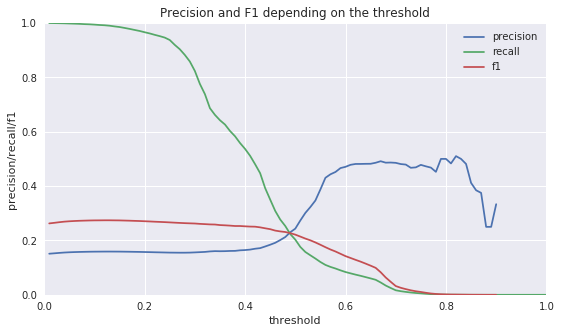

In [115]:
X_train, X_test, y_train, y_test = \
train_test_split(df.drop(['target'], axis=1), df.target,
                 stratify = df.target,
                 random_state=42, shuffle=True, test_size=0.70)

try:
    y_proba = xgb.predict_proba(X_test.astype(dtype=np.float32))
except ValueError as err:
    colsstr = str(err).split('feature_names mismatch: ')[1].split(' [')[0]
    getcolslist = list(ast.literal_eval(colsstr[1:-1]))
    X_test = X_test[getcolslist]       
    y_proba = xgb.predict_proba(X_test.astype(dtype=np.float32))[:,1]

    
re, pr, f1 = Plot.precision_recall_threshold_curve(y_test, y_proba)

In [116]:
thresholds = np.arange(0.01, 1.05, 0.01)

In [117]:
# Pr/Re intersection point
intersec_arg = np.argwhere(np.isclose(re, pr, atol=0.02)).ravel()[0]
intersec_arg, pr[intersec_arg]

(48, 0.2301642931632845)

In [118]:
# point at which F1 becomes maximum
f1_max_indx = np.argwhere(np.array(f1) == np.array(f1)[~np.isnan(f1)].max()).ravel()[0]
f1_max_indx

12

In [121]:
# choose an average threshold point in order to maximize Re but not to degrage Pr simultaneosly 
avg_indx =f1_max_indx + np.round(0.5*(intersec_arg - f1_max_indx )).astype(int)
avg_indx

30

In [122]:
y_pred = binarize(y_proba.reshape(-1, 1), threshold=thresholds[avg_indx]).reshape(-1)
recall_ts, precision_ts, f1_ts =  get_metrics(y_pred.astype(int), y_test.astype(int))

              precision    recall  f1-score   support

           0    0.86766   0.26052   0.40073    339650
           1    0.15687   0.77592   0.26098     60228

   micro avg    0.33815   0.33815   0.33815    399878
   macro avg    0.51227   0.51822   0.33085    399878
weighted avg    0.76061   0.33815   0.37968    399878



In [123]:
average_precision_score(y_test, y_proba)

0.21702394242379347

### Incremental UPTraining

In [ ]:
cls = xgb

for i, data in enumerate(tqdm_notebook(datacsv)):
    
    spStopCheck = sp.sc._jsc.sc().isStopped()
    if not spStopCheck:
        print("### Spark context is still alive!")
    else:
        sp.sc.stop()
        sp = spark(schema='sbx_team_digitcamp', 
                   sparkVersion='2.2',
                   dynamic_alloc=False,
                   numofinstances=40, 
                   numofcores=8,
                   kerberos_auth=False) 
        hive = sp.sql
        
    print("...working with file--> {}".format(data))
       
#    tr_sdf = hive.read \
#              .format('com.databricks.spark.csv') \
#              .option('sep', ';') \
#              .option('header', True) \
#              .option("quote", '\u0000') \
#              .load(data)

#     df = tr_sdf.toPandas()
#     pos = df['target'].sum()
#     cnt = df['target'].count()
#     frac = np.around(pos/(cnt-pos)*100, 3)
#     print("class balance at {} step: {}".format(i,frac))

    hdfsfile='hdfs:///'+data
    sp.sc.addFile(hdfsfile)
    df = pd.read_csv(filepath_or_buffer = SparkFiles.get(hdfsfile.split('csv/')[-1]), 
                     sep = ';', nrows=None, 
                     engine='python',
                     dtype = dict({col: np.float32 for col in cols if col not in ('target')}, **{'target' : np.int32})
                     ) 
    
    df.drop(columns=['sum_open_click_camp'], inplace=True)
    
    print("...Start of incremental training #{}".format(i)) 
    X_train, X_test, y_train, y_test = \
    train_test_split(df.drop(['target'], axis=1), df.target,
                     stratify = df.target,
                     random_state=42, shuffle=True, test_size=0.1)
       
    xgb_params = dict(xgb_params,**{'n_jobs'   : 15,
                                    'verbosity': 1,
                                    'update':'refresh',
                                    'process_type':'default',
                                    'refresh_leaf':True,                                    
                                    'xgb_model': cls})

    del df
    gc.collect()
    
#     X_train = X_train.astype(dtype=np.float32)
    cls = XGBClassifier(**xgb_params)  
    cls.fit(X_train, y_train)
    
    del X_train, y_train
    gc.collect()
    
    print("...End of incremental training #{}".format(i))
    print("#"*60)   
    X_test = X_test.astype(dtype=np.float32)
    y_pred = cls.predict(X_test)
    
    del X_test
    gc.collect()
    
    y_pred = y_pred.astype(int) 
    y_test = y_test.astype(int)
    recall_ts, precision_ts, f1_ts =  get_metrics(y_pred, y_test)
    print('Hold Out: ')
    print("Precision: {:7.5f}, Recall: {:7.5f}, F_1: {:7.5f}".format(precision_ts, recall_ts, f1_ts))
    print("#"*60)
    
    del y_test, y_pred
    gc.collect()
    sleep(1)

### Train on whole data

In [ ]:
hdfsfile='hdfs:///'+datacsv[0]
sp.sc.addFile(hdfsfile)

df = pd.read_csv(filepath_or_buffer = SparkFiles.get(hdfsfile.split('csv/')[-1]), 
                 sep = ';', nrows=0, 
                 engine='python',
                 dtype = dict({col: np.float32 for col in cols if col not in ('target')}, **{'target' : np.int32})
                 ) 


for i, data in enumerate(tqdm_notebook(datacsv)):
    
    spStopCheck = sp.sc._jsc.sc().isStopped()
    if not spStopCheck:
        print("### Spark context is still alive!")
    else:
        sp.sc.stop()
        sp = spark(schema='sbx_team_digitcamp', 
                   sparkVersion='2.2',
                   dynamic_alloc=False,
                   numofinstances=40, 
                   numofcores=8,
                   kerberos_auth=False) 
        hive = sp.sql
        
    print("...working with file--> {}".format(data))
    
    hdfsfile='hdfs:///'+data
    sp.sc.addFile(hdfsfile)
    dftmp = pd.read_csv(filepath_or_buffer = SparkFiles.get(hdfsfile.split('csv/')[-1]), 
                     sep = ';', nrows=None, 
                     engine='python',
                     dtype = dict({col: np.float32 for col in cols if col not in ('target')}, **{'target' : np.int32})
                     ) 
    
    
    df = pd.concat([df,dftmp], ignore_index=True)
    del dftmp
    gc.collect()
    print(df.shape)    

## Clean tmp files

In [7]:
hive.sql("drop table if exists sbx_team_digitcamp.tmp_resp_inn_kpp_train_sampl")

DataFrame[]

In [12]:
subprocess.call(['hdfs', 'dfs', '-rm', '-r', '-f', '-skipTrash', '/user/ektov/csv/*'])

0